In [2]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
import time
#from ZIFA import ZIFA
#from ZIFA import block_ZIFA
import pylab

In [3]:
%load_ext rpy2.ipython

In [5]:
%%R
library(scde, quietly = TRUE)
library(DESeq2, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(made4, quietly = TRUE)
library(irlba, quietly = TRUE)
library(scater)
library(scran)
library(ComplexHeatmap)
library(genefilter)
library(ccRemover)
library(Rtsne)

In [29]:
%%R
GeneName <- read.table("/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/GeneNames.txt")

In [30]:
%%R
cdStromal <- read.table("/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/AllHtseqCountsStromal.tsv", sep=",",header=TRUE, row.names=1)
colnames(cdStromal) <- paste0("Stromal_C",c(1:96))
rownames(cdStromal) <- make.names(GeneName$V1, unique=TRUE)
#colnames(cdStromal) <- sub("_.*", "_Stromal", colnames(cdStromal))
head(cdStromal)

         Stromal_C1 Stromal_C2 Stromal_C3 Stromal_C4 Stromal_C5 Stromal_C6
TSPAN6            0          0          0          0          0          0
TNMD              0          0          0          0          0          0
DPM1              0          0          0          0          0          0
SCYL3             0          0          0          0          0          0
C1orf112          0          0          0          0          0          0
FGR               0          0          0          0          0          0
         Stromal_C7 Stromal_C8 Stromal_C9 Stromal_C10 Stromal_C11 Stromal_C12
TSPAN6            0          0          0           0           0           0
TNMD              0          0          0           0           0           0
DPM1              0          0          0           0           0           0
SCYL3             0          0          0           0           0           0
C1orf112          0          0          0           0           0           0
FGR    

In [31]:
%%R
cdTumour <- read.table("/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/AllHtseqCountsTumour.tsv", sep=",",header=TRUE, row.names=1)
colnames(cdTumour) <- paste0("Tumor_C",c(1:96))
rownames(cdTumour) <- make.names(GeneName$V1, unique=TRUE)
#colnames(cdTumour) <- sub("_.*", "_Tumour", colnames(cdTumour))
head(cdTumour)

         Tumor_C1 Tumor_C2 Tumor_C3 Tumor_C4 Tumor_C5 Tumor_C6 Tumor_C7
TSPAN6          6        0        8        5      150        0       56
TNMD            0        0        0        0        0        0        0
DPM1          109      189       37      177      101      237       36
SCYL3           0        7        0        0        0       10        0
C1orf112        0        8        0        0        0        2        7
FGR             0        0        0        0        0        0        0
         Tumor_C8 Tumor_C9 Tumor_C10 Tumor_C11 Tumor_C12 Tumor_C13 Tumor_C14
TSPAN6          1       28        95         4         0       469         0
TNMD            0        0         0         0         0         0         0
DPM1           35       83        84       125         3         0        59
SCYL3           5        1         3         0         0         0        15
C1orf112        0        0         2         2         0         0        12
FGR             0        0        

In [32]:
%%R
cdAll <- cbind(cdStromal, cdTumour)
head(cdAll)

         Stromal_C1 Stromal_C2 Stromal_C3 Stromal_C4 Stromal_C5 Stromal_C6
TSPAN6            0          0          0          0          0          0
TNMD              0          0          0          0          0          0
DPM1              0          0          0          0          0          0
SCYL3             0          0          0          0          0          0
C1orf112          0          0          0          0          0          0
FGR               0          0          0          0          0          0
         Stromal_C7 Stromal_C8 Stromal_C9 Stromal_C10 Stromal_C11 Stromal_C12
TSPAN6            0          0          0           0           0           0
TNMD              0          0          0           0           0           0
DPM1              0          0          0           0           0           0
SCYL3             0          0          0           0           0           0
C1orf112          0          0          0           0           0           0
FGR    

In [33]:
%%R
# clean up the dataset
cdFiltered <- clean.counts(cdAll, min.lib.size=500, min.reads = 10, min.detected = 5)
print(dim(cdFiltered))

[1] 19107   185


In [34]:
%%R
StromalNo <- (sum(sapply(regmatches(colnames(cdFiltered), gregexpr("Stromal", colnames(cdFiltered))), length)))
TumorNo <- (sum(sapply(regmatches(colnames(cdFiltered), gregexpr("Tumor", colnames(cdFiltered))), length)))
print(paste0("Stromal Cells: ",StromalNo))
print(paste0("Tumor Cells: ",TumorNo))

[1] "Stromal Cells: 89"
[1] "Tumor Cells: 96"


In [35]:
%%R
FilteredDataInfo <- data.frame(Cell=colnames(cdFiltered), Status=c(rep('Stormal',StromalNo), rep('Tumor',TumorNo)))
rownames(FilteredDataInfo ) <- colnames(cdFiltered)

In [36]:
%%R
pd <- new("AnnotatedDataFrame", data = FilteredDataInfo)
rownames(pd) <- pd$Cell
cdScesetFiltered <- newSCESet(countData = cdFiltered, phenoData = pd)

__plotPCA__ uses __exprs__ value. exprs(object): returns the matrix of feature expression values. Typically these should be log2(counts-per-million) values or log2(reads-per-kilobase-per-million-mapped), appropriately normalised of course. The package will generally assume that these are the values to use for expression.

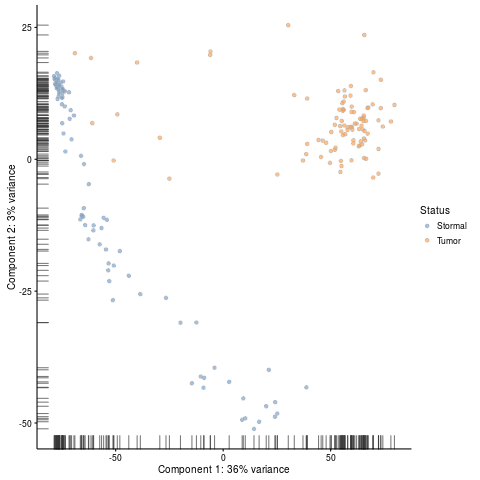

In [37]:
%%R
plotPCA(cdScesetFiltered, ncomponents = 2, colour_by = "Status", ntop=10000)

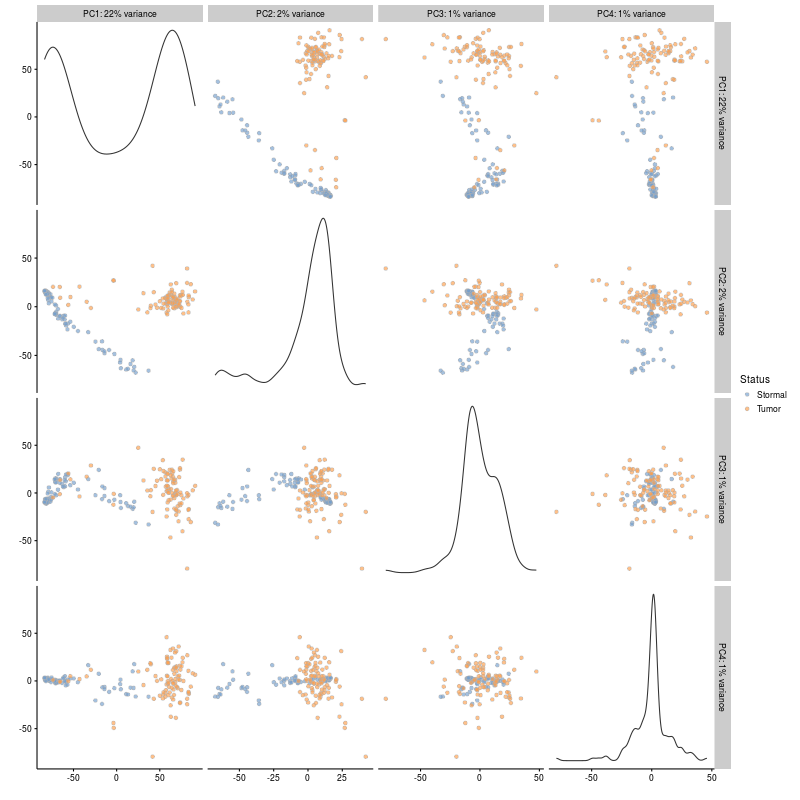

In [38]:
%%R -w 800 -h 800
plotPCA(cdScesetFiltered, ncomponents = 4, colour_by = "Status", ntop=dim(cdFiltered)[1])

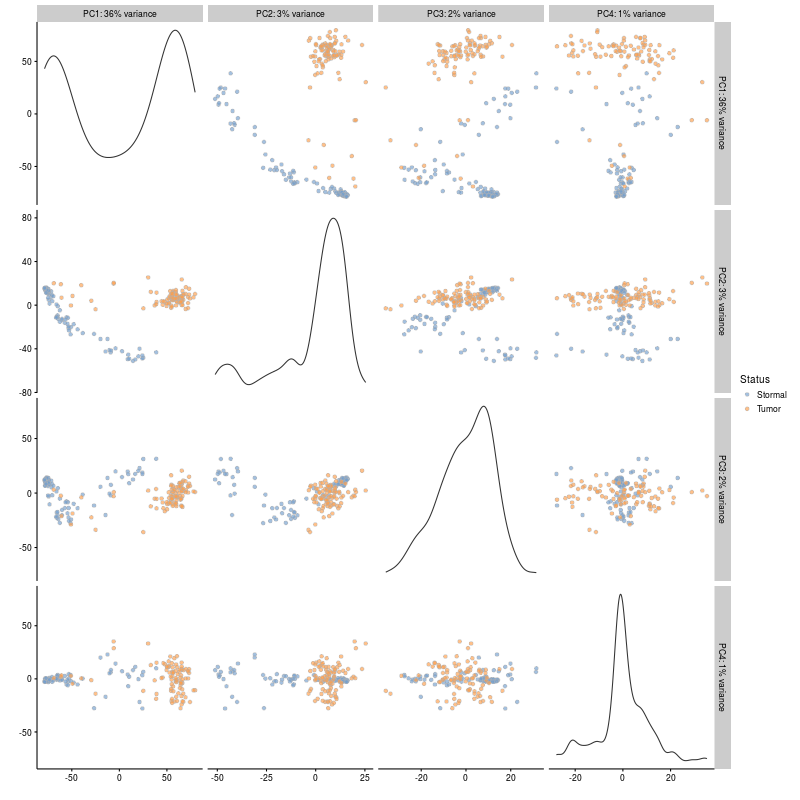

In [39]:
%%R -w 800 -h 800
plotPCA(cdScesetFiltered, ncomponents = 4, colour_by = "Status", ntop=10000)

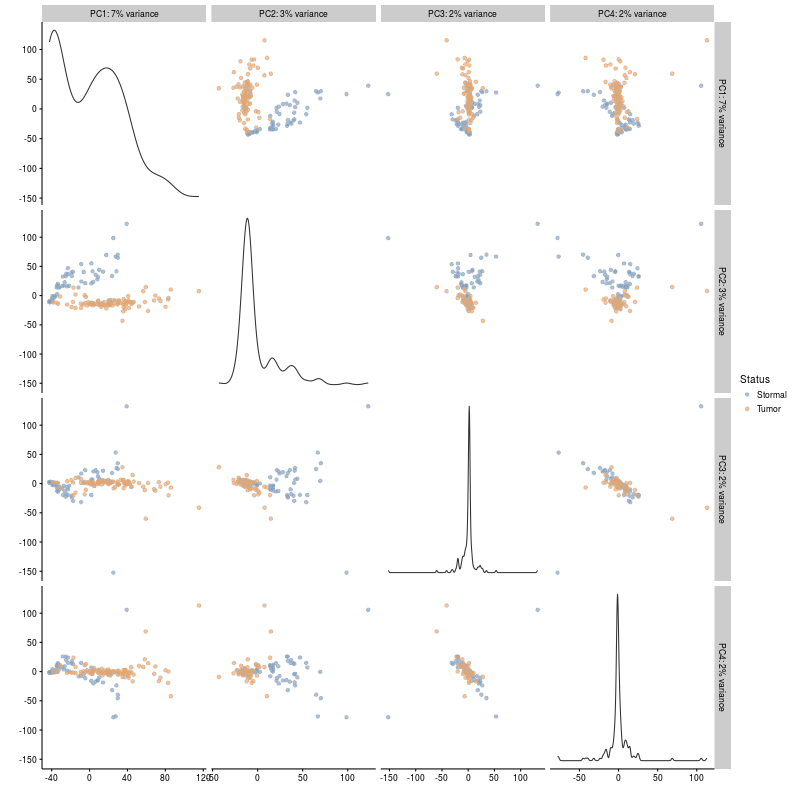

In [40]:
%%R -w 800 -h 800
plotPCA(cdScesetFiltered, ncomponents = 4, colour_by = "Status", ntop=dim(cdFiltered)[1], exprs="counts")

In [41]:
%%R
save.image("Louisa_Workspace.RData")

In [42]:
%%R
# Taking CPM normalized value for clustering from cdScesetFiltered
cdFilteredForCluster <- exprs(cdScesetFiltered)
cdFilteredForCluster <- cdFilteredForCluster[order(rowVars(cdFilteredForCluster), decreasing = TRUE)[1:10000],]
colAnnot = data.frame(type = c(rep('Stormal',StromalNo), rep('Tumor',TumorNo)))
ha = HeatmapAnnotation(df = colAnnot)

###############################
# I turned this Heatmap option off as it took lots of memory to run from jupyter notebook
#png("CPM_Normalized_Low_Threshold_HirerClust.png", height=1000, width=1700)
#Heatmap(cdFilteredForCluster, show_row_dend=FALSE, show_row_names = FALSE, column_names_gp = gpar(fontsize = 9), top_annotation = ha)
#dev.off()

In [43]:
%%R
head(cdFilteredForCluster)

        Stromal_C1 Stromal_C2 Stromal_C3 Stromal_C4 Stromal_C5 Stromal_C6
ARRDC3    0.000000   0.000000   0.000000   0.000000    0.00000   4.750183
BICC1     0.000000   0.000000   0.000000   0.000000    0.00000   0.000000
TLK1      0.000000   0.000000   0.000000   0.000000    0.00000   4.750183
CP        0.000000   0.000000   0.000000   0.000000    0.00000   0.000000
TBL1XR1   5.917658   3.248104   5.908536   9.651599    0.00000   0.000000
IL33      4.941329  14.767631   6.485471   9.844020   13.45565  11.614878
        Stromal_C7 Stromal_C8 Stromal_C9 Stromal_C10 Stromal_C11 Stromal_C12
ARRDC3    0.000000    0.00000   0.000000    0.000000    0.000000    0.000000
BICC1     0.000000    0.00000   0.000000    0.000000    0.000000    0.000000
TLK1      0.000000    0.00000   0.000000    4.668503    0.000000    5.950545
CP        0.000000    0.00000   0.000000    0.000000    0.000000   12.481867
TBL1XR1   4.588123    0.00000   0.000000    4.668503    6.082207    0.000000
IL33      9.310493  

In [44]:
%%R
StromalReassigned = sort(c(46,47,41,44,73,28,42,31,67,60,16,43,33,34,70,49,38,24,72),decreasing=FALSE)
TumorReassigned = sort(c(13,31,22,62,12,34,59,60),decreasing=FALSE)
StromalReasName = paste0("Stromal_C", StromalReassigned)
TumorReasName = paste0("Tumor_C", TumorReassigned)

In [46]:
%%R
cdFilteredReas <- cdFiltered
rownames(cdFilteredReas) <- make.names(gsub("\\..*","",rownames(cdFilteredReas)), unique=TRUE)
colnames(cdFilteredReas)[colnames(cdFilteredReas) %in% StromalReasName] <- paste0("Re_",StromalReasName)
colnames(cdFilteredReas)[colnames(cdFilteredReas) %in% TumorReasName] <- paste0("Re_",TumorReasName)

In [207]:
%%R
head(rownames(cdFilteredReas))

[1] "TSPAN6"   "DPM1"     "SCYL3"    "C1orf112" "CFH"      "FUCA2"   


In [48]:
%%R
write.csv(cdFilteredReas, 'cdFilteredReasGeneAnnot.csv')

In [49]:
%%R
FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredReas), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredForClusterReas)))
rownames(FilteredDataInfoReas) <- colnames(cdFilteredReas)
#gsub("\\_C*","",colnames(cdFilteredForClusterReas))

In [68]:
%%R
FilteredDataInfoReas$Status

  [1] Stromal    Stromal    Stromal    Stromal    Stromal    Stromal   
  [7] Stromal    Stromal    Stromal    Stromal    Stromal    Stromal   
 [13] Stromal    Stromal    Stromal    Re_Stromal Stromal    Stromal   
 [19] Stromal    Stromal    Stromal    Stromal    Stromal    Re_Stromal
 [25] Stromal    Stromal    Stromal    Re_Stromal Stromal    Stromal   
 [31] Re_Stromal Stromal    Re_Stromal Re_Stromal Stromal    Stromal   
 [37] Stromal    Re_Stromal Stromal    Stromal    Re_Stromal Re_Stromal
 [43] Re_Stromal Re_Stromal Stromal    Re_Stromal Re_Stromal Stromal   
 [49] Re_Stromal Stromal    Stromal    Stromal    Stromal    Stromal   
 [55] Stromal    Stromal    Stromal    Stromal    Re_Stromal Stromal   
 [61] Stromal    Stromal    Stromal    Stromal    Stromal    Re_Stromal
 [67] Stromal    Stromal    Re_Stromal Stromal    Re_Stromal Re_Stromal
 [73] Stromal    Stromal    Stromal    Stromal    Stromal    Stromal   
 [79] Stromal    Stromal    Stromal    Stromal    Stromal    Str

In [50]:
%%R
pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
cdScesetFilteredReas <- newSCESet(countData = cdFilteredReas, phenoData = pd)

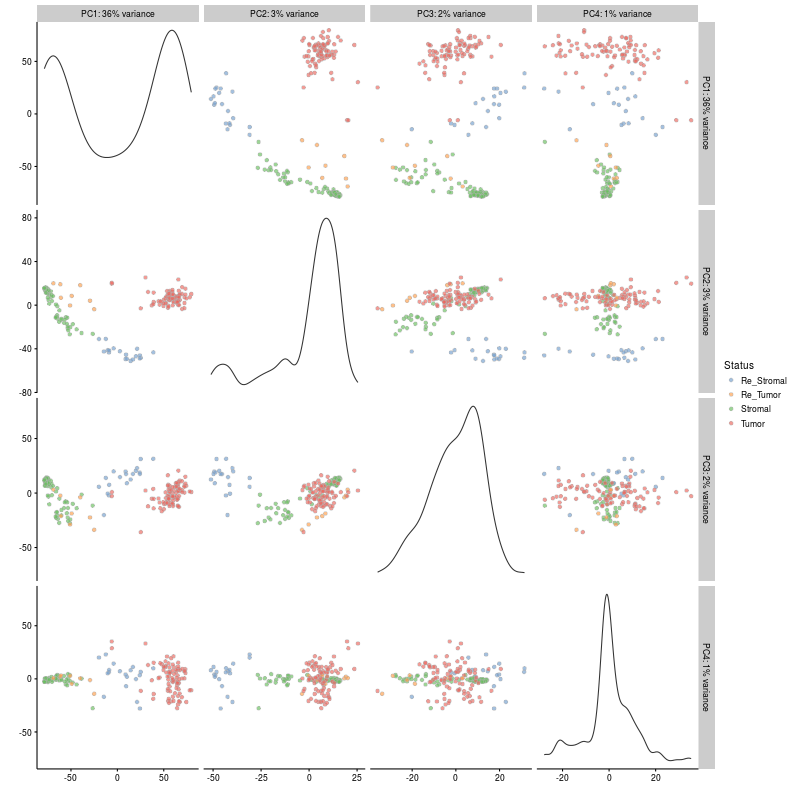

In [52]:
%%R -w 800 -h 800
plotPCA(cdScesetFilteredReas, ncomponents = 4, colour_by = "Status", ntop=10000)

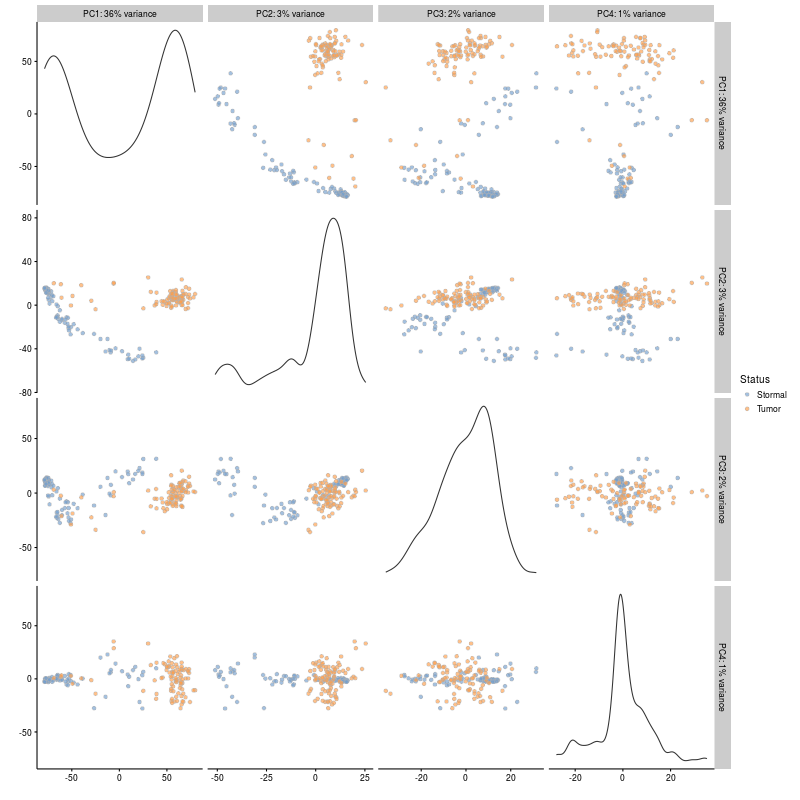

In [53]:
%%R -w 800 -h 800
plotPCA(cdScesetFiltered, ncomponents = 4, colour_by = "Status", ntop=10000)

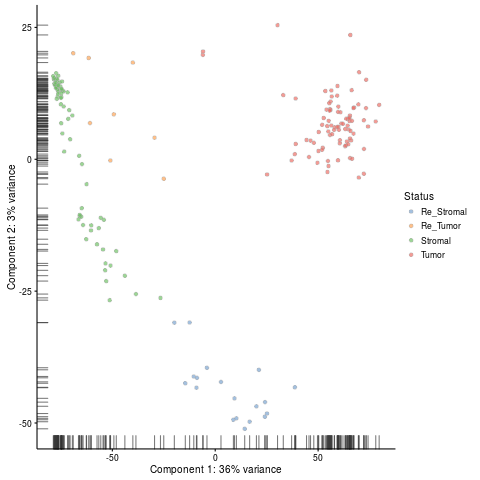

In [54]:
%%R
plotPCA(cdScesetFilteredReas, ncomponents = 2, colour_by = "Status", ntop=10000)

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: The variable filter_on_total_counts only has one unique value, so R^2 is not meaningful.
This variable will not be plotted.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: The variable filter_on_total_features only has one unique value, so R^2 is not meaningful.
This variable will not be plotted.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: The variable exprs_feature_controls only has one unique value, so R^2 is not meaningful.
This variable will not be plotted.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: The variable pct_exprs_feature_controls only has one unique value, so R^2 is not meaningful.
Th

Coefficients not estimable: x 


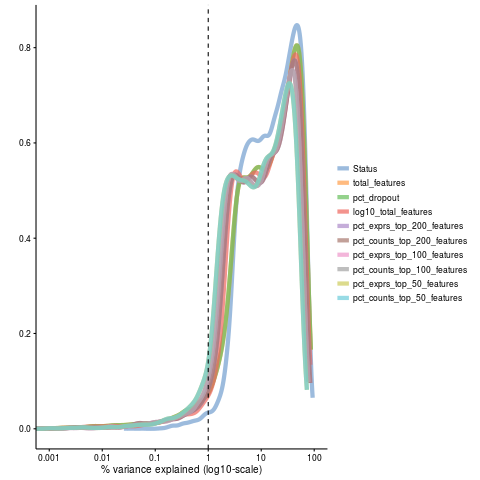

In [197]:
%%R
plotQC(cdScesetFilteredReas, type = "expl")

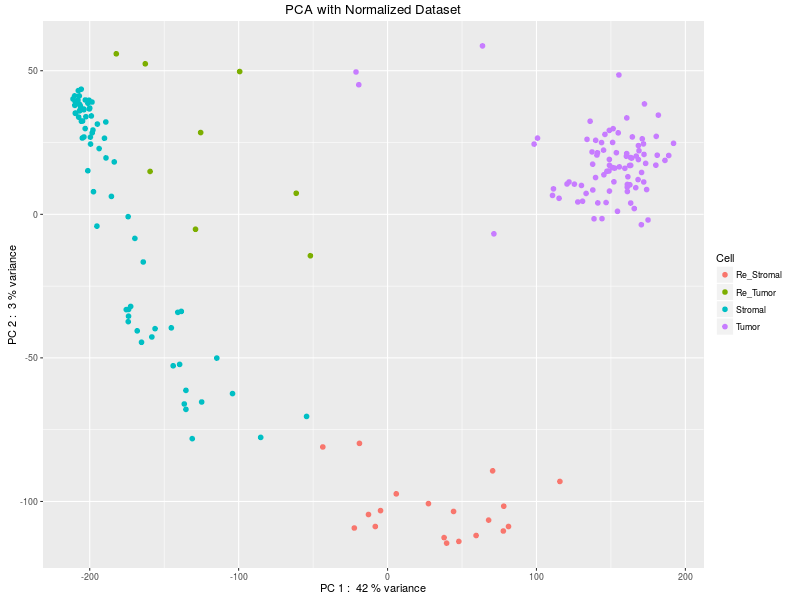

In [245]:
%%R -w 800 -h 600
FinalPCAData <- t(exprs(cdScesetFilteredReas)[1:10000,])
sampleCondition <- FilteredDataInfoReas$Status
#strain <- factor(sampleCondition, levels=c("Stromal", "Tumour"),labels=c("Stromal", "Tumour"))
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with Normalized Dataset")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [80]:
%%R
write.csv(df, "Component_value_For_Reassigned.csv")

NULL


In [55]:
%%R
cdScesetFilteredReas <- calculateQCMetrics(cdScesetFilteredReas)

In [56]:
%%R
save.image("Louisa_Workspace.RData")

In [57]:
%%R
names(pData(cdScesetFilteredReas))

 [1] "Cell"                                 
 [2] "Status"                               
 [3] "total_counts"                         
 [4] "log10_total_counts"                   
 [5] "filter_on_total_counts"               
 [6] "total_features"                       
 [7] "log10_total_features"                 
 [8] "filter_on_total_features"             
 [9] "pct_dropout"                          
[10] "exprs_feature_controls"               
[11] "pct_exprs_feature_controls"           
[12] "filter_on_pct_exprs_feature_controls" 
[13] "pct_exprs_top_50_features"            
[14] "pct_exprs_top_100_features"           
[15] "pct_exprs_top_200_features"           
[16] "counts_feature_controls"              
[17] "pct_counts_feature_controls"          
[18] "filter_on_pct_counts_feature_controls"
[19] "pct_counts_top_50_features"           
[20] "pct_counts_top_100_features"          
[21] "pct_counts_top_200_features"          
[22] "n_detected_feature_controls"          
[23] "expr

In [58]:
%%R
plot.scores.self <- function(df, Cell, Status,legend.title, plot.title){  
  
  df$Status <- as.factor(Status) 
  p<-ggplot(data=df, aes(x=x,y=y,color=Status))
  p+geom_point(size=2)+
    xlab("G1 score")+
    ylab("G2M score")+
    ylim(0,1)+
    xlim(0,1)+
    ggtitle(plot.title)+
    theme(axis.title.x = element_text(size=10, vjust=-2),
          axis.text.x  = element_text( size=10),
          axis.title.y = element_text( size=10,vjust=2),
          axis.text.y  = element_text( size=10)) +
    theme(plot.margin=unit(c(1,1,1.5,1.2),"cm"))+
    theme(legend.text=element_text(size=10),#size of legend
          legend.title=element_text(size=10), 
          plot.title = element_text(size=20, face="bold"))+
    scale_color_discrete(name=legend.title)+
    geom_segment(aes(x = 1/2, y = 0, xend=1/2, yend=1/2),colour="black") + 
    geom_segment(aes(x = 0, y = 1/2, xend=1/2, yend=1/2),colour="black") +
    geom_segment(aes(x = 1/2, y = 1/2, xend=1, yend=1),colour="black") +
    annotate("text", x=0.05, y=0.05, label="S", size=8)+
    annotate("text", x=0.95, y=0.25, label="G1", size=8)+
    annotate("text", x=0.25, y=0.95, label="G2M", size=8)+
    geom_text(data=df,aes(label=Cell),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")  
  
}

In [5]:
%%R
load("Louisa_Workspace.RData")

In [46]:
%%R
cdFilteredReasGeneID <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/cdFilteredReas.csv', row.names=1, header=TRUE)

FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredReasGeneID), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredReasGeneID)))
rownames(FilteredDataInfoReas) <- colnames(cdFilteredReasGeneID)
pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
cdScesetFilteredReasGeneID <- newSCESet(countData = cdFilteredReasGeneID, phenoData = pd)

In [16]:
%%R
write.csv(exprs(cdScesetFilteredReasGeneID), 'GeneID_log(cpm)_normalized.csv')

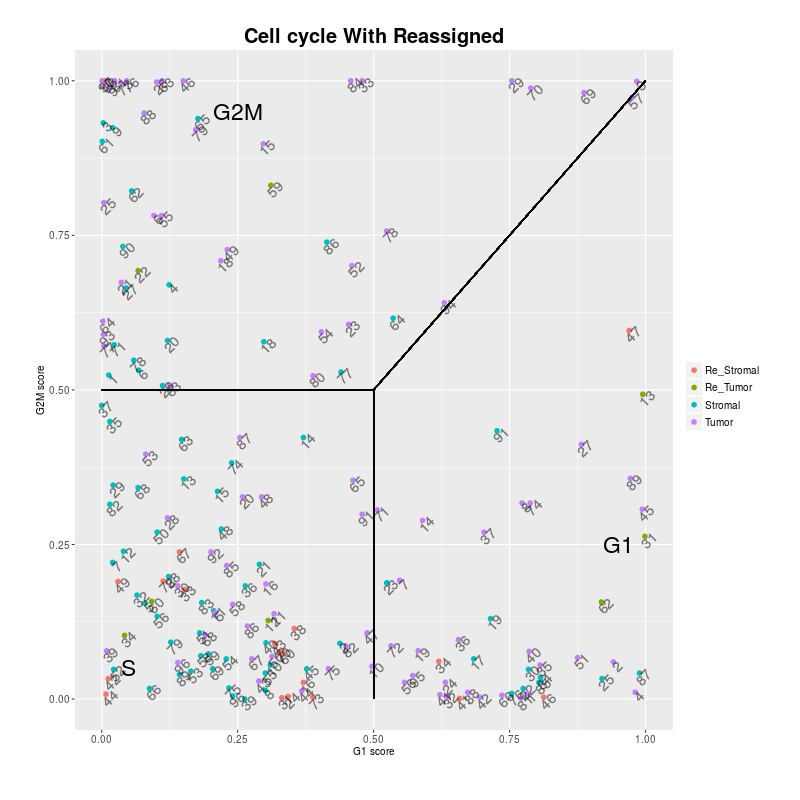

In [262]:
%%R -w 800 -h 800
############
### Commenting the other line as cyclone run outs of memory if we run it here
#cdFilteredReasGeneID <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/cdFilteredReas.csv', row.names=1, header=TRUE)
#FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredReas), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredForClusterReas)))
#rownames(FilteredDataInfoReas) <- colnames(cdFilteredReas)
#pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
#rownames(pd) <- pd$Cell
#cdScesetFilteredReasGeneID <- newSCESet(countData = cdFilteredReasGeneID, phenoData = pd)
#hg.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))
#assigned <- cyclone(cdScesetFilteredReasGeneID, pairs=hg.pairs)
#head(assigned$scores)
#phase <- rep("S", ncol(cdScesetFilteredReas))
#phase[assigned$scores$G1 > 0.5] <- "G1"
#phase[assigned$scores$G2M > 0.5] <- "G2M"
#phase[assigned$scores$G1 > 0.5 & assigned$scores$G2M > 0.5] <- "unknown"
#table(phase)
#phase
#assigned$scores
#labels.qseq <- rep("Cell", length(colnames(cdFilteredReas)) )
#df.scores<-data.frame(x=assigned$scores[,1], 
#                      y=assigned$scores[,3], 
#                      z=labels.qseq )

plot.scores.self(df.scores,gsub('([A-z]+)', '\\2',(cdScesetFilteredReas$Cell)), cdScesetFilteredReas$Status, legend.title="",plot.title="Cell cycle With Reassigned")


In [255]:
%%R
rownames(assigned$scores) <- cdScesetFilteredReas$Cell
write.csv(assigned$scores, "CellCycleAssignment.csv")

In [259]:
%%R
CycleAssigned <- data.frame(Cells = cdScesetFilteredReas$Cell, Phases = phase )
write.csv(CycleAssigned, "CycleAssigned.csv")

In [59]:
%%R
write.csv(exprs(cdScesetFilteredReas), "log2(cpm)_normalized_Filtered_Gene_Annot.csv")

In [66]:
%%R
write.csv(exprs(cdScesetFilteredReas)[grep('TP53',rownames(cdScesetFilteredReas), ignore.case=FALSE),], 'AllTP53.csv')

In [81]:
%%R
write.csv(get_exprs(cdScesetFilteredReas, "cpm"), "cpm_normalized_Filtered_Gene_Annot.csv")

## Removing cell-cycle effect

In [17]:
%%R
head(exprs(cdScesetFilteredReasGeneID))

                Stromal_C1 Stromal_C2 Stromal_C3 Stromal_C4 Stromal_C5
ENSG00000000003          0          0          0          0          0
ENSG00000000419          0          0          0          0          0
ENSG00000000457          0          0          0          0          0
ENSG00000000460          0          0          0          0          0
ENSG00000000971          0          0          0          0          0
ENSG00000001036          0          0          0          0          0
                Stromal_C6 Stromal_C7 Stromal_C8 Stromal_C9 Stromal_C10
ENSG00000000003          0          0          0   0.000000           0
ENSG00000000419          0          0          0   0.000000           0
ENSG00000000457          0          0          0   0.000000           0
ENSG00000000460          0          0          0   0.000000           0
ENSG00000000971          0          0          0   0.000000           0
ENSG00000001036          0          0          0   4.428639           0

In [6]:
%%R
hg.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))

In [250]:
%%R
x <- t(scale(t(exprs(cdScesetFilteredReasGeneID)), scale=FALSE, center=TRUE))
allGenes <- data.frame(geneName=rownames(x), Status=FALSE)
allGenes[as.character(allGenes$geneName) %in% hg.pairs$G1$first,2] = TRUE
allGenes[as.character(allGenes$geneName) %in% hg.pairs$G2M$first,2] = TRUE
allGenes[as.character(allGenes$geneName) %in% hg.pairs$S$first,2] = TRUE
if.cc <- allGenes[,2]
dat <-list(x =x ,if.cc = if.cc)

In [251]:
%%R
CellCycleRemoved <- ccRemover.main(dat,cutoff=3, max.it=4, nboot=200, ntop=10)


Iteration  1 ...
Bootstrapping 1 ...
Bootstrapping 2 ...
Bootstrapping 3 ...
Bootstrapping 4 ...
Bootstrapping 5 ...
Bootstrapping 6 ...
Bootstrapping 7 ...
Bootstrapping 8 ...
Bootstrapping 9 ...
Bootstrapping 10 ...
Bootstrapping 11 ...
Bootstrapping 12 ...
Bootstrapping 13 ...
Bootstrapping 14 ...
Bootstrapping 15 ...
Bootstrapping 16 ...
Bootstrapping 17 ...
Bootstrapping 18 ...
Bootstrapping 19 ...
Bootstrapping 20 ...
Bootstrapping 21 ...
Bootstrapping 22 ...
Bootstrapping 23 ...
Bootstrapping 24 ...
Bootstrapping 25 ...
Bootstrapping 26 ...
Bootstrapping 27 ...
Bootstrapping 28 ...
Bootstrapping 29 ...
Bootstrapping 30 ...
Bootstrapping 31 ...
Bootstrapping 32 ...
Bootstrapping 33 ...
Bootstrapping 34 ...
Bootstrapping 35 ...
Bootstrapping 36 ...
Bootstrapping 37 ...
Bootstrapping 38 ...
Bootstrapping 39 ...
Bootstrapping 40 ...
Bootstrapping 41 ...
Bootstrapping 42 ...
Bootstrapping 43 ...
Bootstrapping 44 ...
Bootstrapping 45 ...
Bootstrapping 46 ...
Bootstrapping 47 ...
Boot

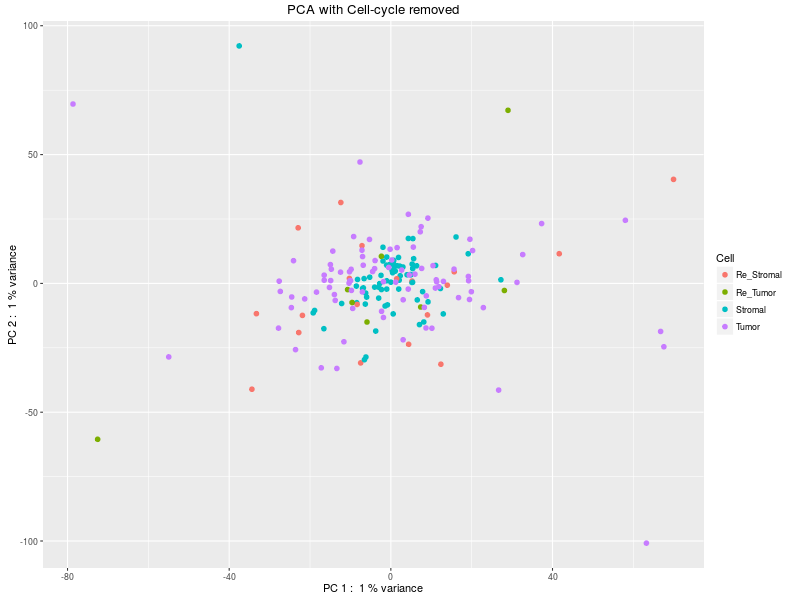

In [252]:
%%R -w 800 -h 600
FinalPCAData <- t(CellCycleRemoved[order(rowVars(CellCycleRemoved), decreasing=TRUE)[1:10000],])
sampleCondition <- FilteredDataInfoReas$Status
#strain <- factor(sampleCondition, levels=c("Stromal", "Tumour"),labels=c("Stromal", "Tumour"))
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with Cell-cycle removed")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [195]:
%%R
#set.seed(1)
tsne_out <- Rtsne(t(exprs(cdScesetFilteredReasGeneID)),check_duplicates = FALSE, pca = TRUE, 
              perplexity=30, theta=0.5, dims=2)

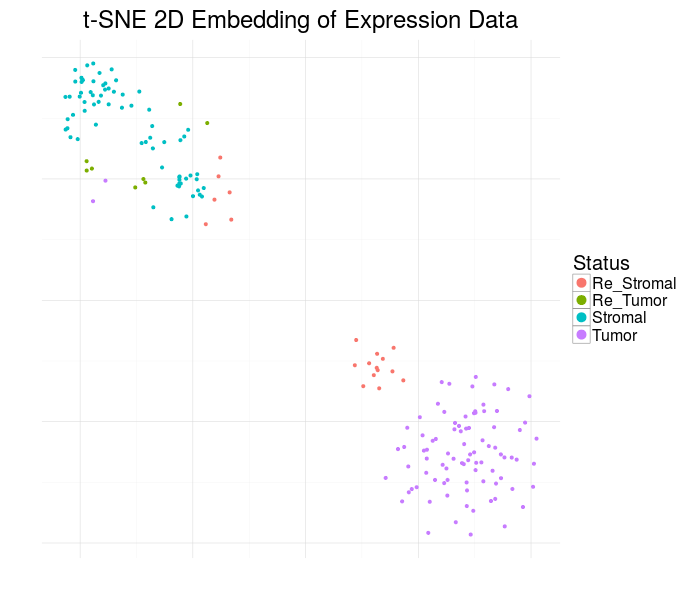

In [196]:
%%R -w 700 -h 600
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=Status)) +
     geom_point(size=1.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

In [95]:
%%R
cdCellCycleCorrected <- CellCycleRemoved
FilteredDataInfoReas <- data.frame(Cell=colnames(cdCellCycleCorrected), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdCellCycleCorrected)))
rownames(FilteredDataInfoReas) <- colnames(cdCellCycleCorrected)
pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
cdScesetCellCycleCorrected <- newSCESet(countData = cdCellCycleCorrected, phenoData = pd)

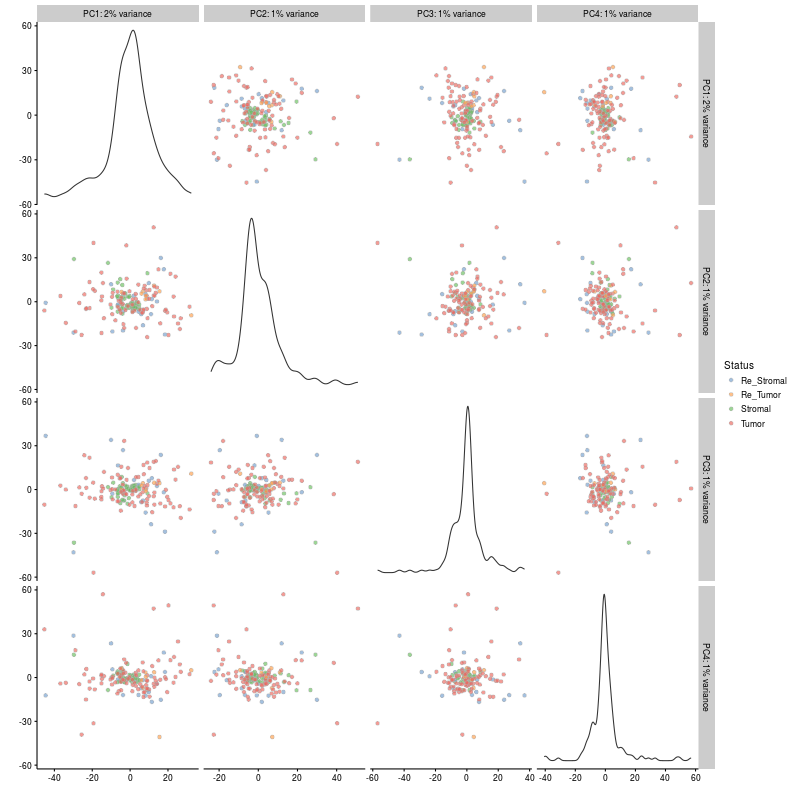

In [101]:
%%R -w 800 -h 800
plotPCA(cdScesetCellCycleCorrected, ncomponents = 4, colour_by = "Status", ntop=10000, exprs="counts")

## Cell-cycle Gene from Evan Z. Macosko

In [8]:
%%R
hgCellCycle <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/Cell-Cycle-Gene_Evan_Macosko.txt', header=TRUE)
x <- t(scale(t(exprs(cdScesetFilteredReasGeneID)), scale=FALSE, center=TRUE))
allGenes <- data.frame(geneName=rownames(x), Status=FALSE)
allGenes[as.character(allGenes$geneName) %in% hgCellCycle$Ensembl.Gene.ID,2] = TRUE
if.cc <- allGenes[,2]
dat <-list(x =x ,if.cc = if.cc)


Error in exprs(cdScesetFilteredReasGeneID) : 
  object 'cdScesetFilteredReasGeneID' not found


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in exprs(cdScesetFilteredReasGeneID) : 
  object 'cdScesetFilteredReasGeneID' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [206]:
%%R
length(if.cc[if.cc == TRUE])

[1] 526


In [200]:
%%R
CellCycleRemoved <- ccRemover.main(dat,cutoff=3, max.it=4, nboot=200, ntop=10)


Iteration  1 ...
Bootstrapping 1 ...
Bootstrapping 2 ...
Bootstrapping 3 ...
Bootstrapping 4 ...
Bootstrapping 5 ...
Bootstrapping 6 ...
Bootstrapping 7 ...
Bootstrapping 8 ...
Bootstrapping 9 ...
Bootstrapping 10 ...
Bootstrapping 11 ...
Bootstrapping 12 ...
Bootstrapping 13 ...
Bootstrapping 14 ...
Bootstrapping 15 ...
Bootstrapping 16 ...
Bootstrapping 17 ...
Bootstrapping 18 ...
Bootstrapping 19 ...
Bootstrapping 20 ...
Bootstrapping 21 ...
Bootstrapping 22 ...
Bootstrapping 23 ...
Bootstrapping 24 ...
Bootstrapping 25 ...
Bootstrapping 26 ...
Bootstrapping 27 ...
Bootstrapping 28 ...
Bootstrapping 29 ...
Bootstrapping 30 ...
Bootstrapping 31 ...
Bootstrapping 32 ...
Bootstrapping 33 ...
Bootstrapping 34 ...
Bootstrapping 35 ...
Bootstrapping 36 ...
Bootstrapping 37 ...
Bootstrapping 38 ...
Bootstrapping 39 ...
Bootstrapping 40 ...
Bootstrapping 41 ...
Bootstrapping 42 ...
Bootstrapping 43 ...
Bootstrapping 44 ...
Bootstrapping 45 ...
Bootstrapping 46 ...
Bootstrapping 47 ...
Boot

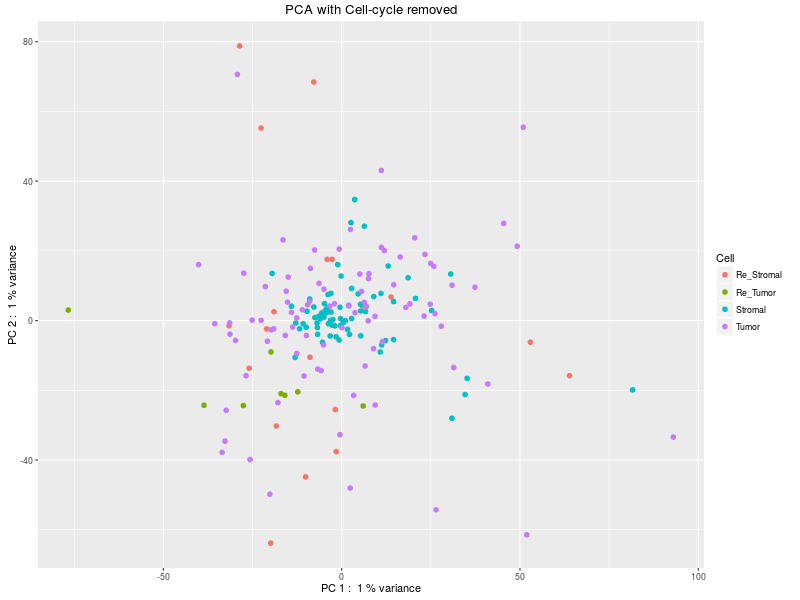

In [201]:
%%R -w 800 -h 600
FinalPCAData <- t(CellCycleRemoved[order(rowVars(CellCycleRemoved), decreasing=TRUE)[1:10000],])
sampleCondition <- FilteredDataInfoReas$Status
#strain <- factor(sampleCondition, levels=c("Stromal", "Tumour"),labels=c("Stromal", "Tumour"))
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with Cell-cycle removed")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

## Infering Copy Number Variation (CNV)
I used inferCNV to infer the copy number variation. Main objective is to see whether we can detect Aneuploidy. The script was changed to support R-3.2.1

In [ ]:
./R/inferCNV.R   --cutoff 4.5   --noise_filter 0.3   --pdf Louisa_Tumor_vs_Stromal_Stromal_NoContamination.pdf   --vis_bound_threshold " -1,1" --ref Louisa_data/Louisa_Stromal_AllContDeleted.txt 
Louisa_data/log2_cpmAllCells_ReAssigned.csv Louisa_data/gencodev24_mod_gen_pos.csv

### Further filtering the genes to came to same gene numbers as shown by Patel et. al.

In [240]:
%%R
cdForFurthFilter <- read.csv('/home/baker/inferCNV/Louisa_data/log2_cpmAllCells_ReAssigned.csv', sep='\t', header=T, row.names=1)
cdForFurthFilter <- cdForFurthFilter[rowMeans(cdForFurthFilter) > 1.75,]
dim(cdForFurthFilter)
#write.table(cdForFurthFilter,'/home/baker/inferCNV/Louisa_data/log2_cpm_FurtherFiltered_TabSep.csv', sep='\t', quote=FALSE)

[1] 6049  185


## Correlation Analysis

In [209]:
%%R
cor.val <- cor(exprs(cdScesetFilteredReasGeneID))

In [211]:
%%R
symnum(cor.val)

               St_C1 St_C2 St_C3 St_C4 St_C5 St_C6 St_C7 St_C8 St_C9 S_C10
Stromal_C1     1                                                          
Stromal_C2           1                                                    
Stromal_C3                 1                                              
Stromal_C4                       1                                        
Stromal_C5           .                 1                                  
Stromal_C6                                   1                            
Stromal_C7                                         1                      
Stromal_C8                                               1                
Stromal_C9           .                 .                       1          
Stromal_C10                                                          1    
Stromal_C11                                                               
Stromal_C12                                                               
Stromal_C13              

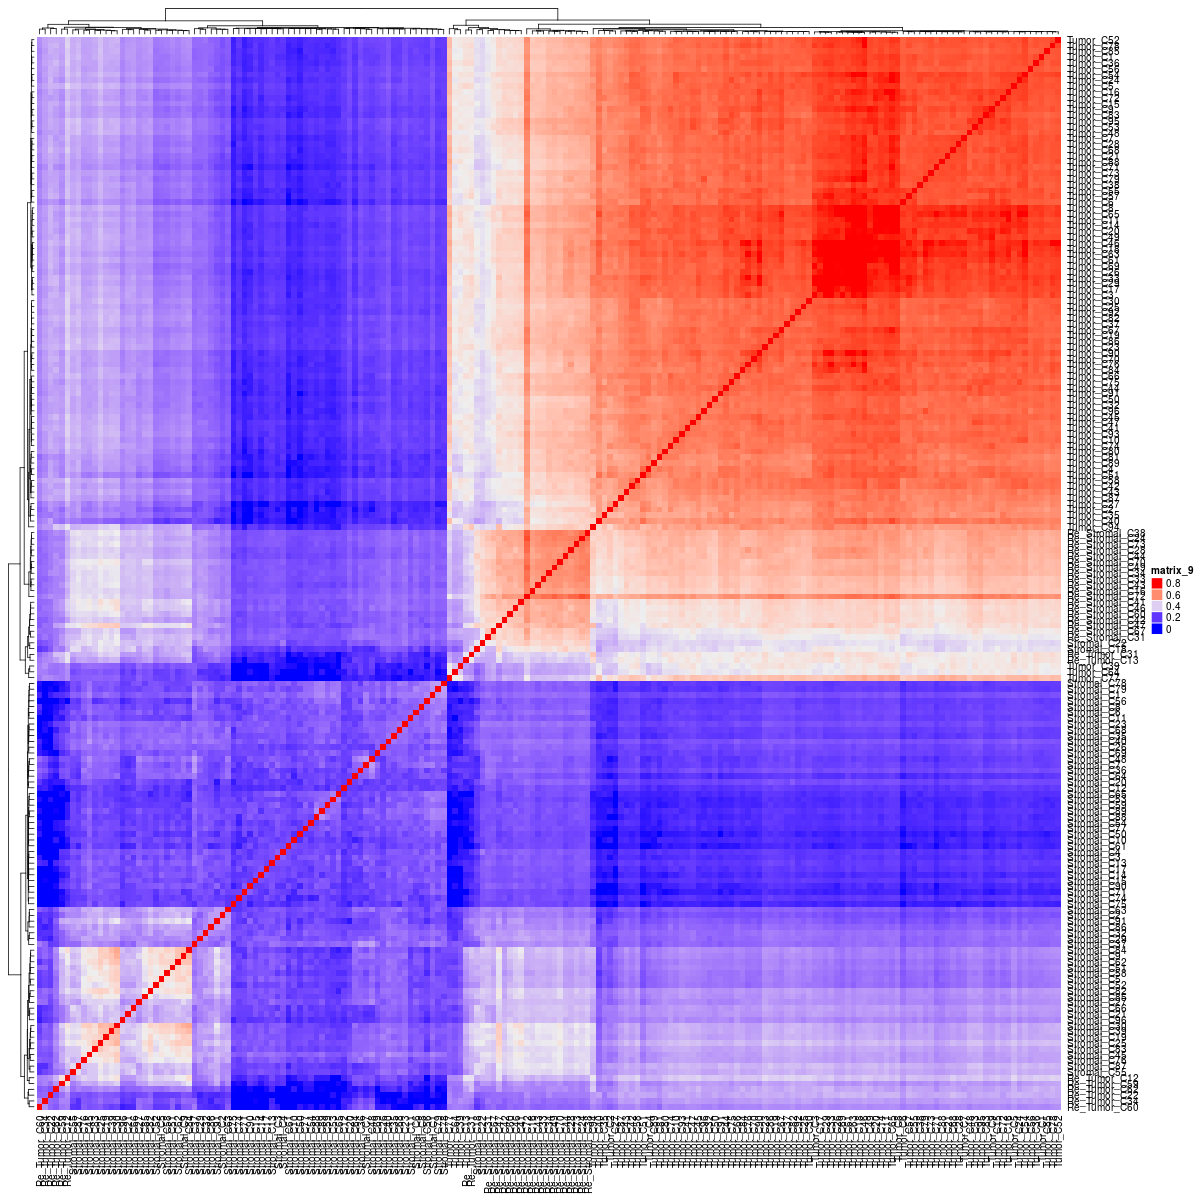

In [220]:
%%R -w 1200 -h 1200
cor.val <- cor(exprs(cdScesetFilteredReasGeneID), method='pearson')
Heatmap(cor.val, row_names_gp = gpar(fontsize = 10), column_names_gp = gpar(fontsize = 10))

In [224]:
%%R
save.image("Louisa_Workspace_withCorrelation.RData")

## DE analysis of Intra-clusters

First we will take out the cells that are grouped into different clusters. Then we will do a DE analysis between those clusters to find out the genes that are significantly differentially expressed between different groups. I am looking to use multiple tools for that, namely

- SCDE
- D3E
- MAST
- BPSC

In [7]:
%%R
load("/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/Heterogeneity_AnalysisReAssigned.RData")

In [8]:
%%R
ClustTree <- cutree(hc,6)
Cluster1 <- names(ClustTree[ClustTree == 1])
Cluster2 <- names(ClustTree[ClustTree == 2])
Cluster3 <- names(ClustTree[ClustTree == 3])
Cluster4 <- names(ClustTree[ClustTree == 4])
Cluster5 <- names(ClustTree[ClustTree == 5])
Cluster6 <- names(ClustTree[ClustTree == 6])

In [11]:
%%R
cdFilteredReas <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/cdFilteredReasGeneAnnot.csv', row.names=1, header=TRUE)
FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredReas), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredReas)))
rownames(FilteredDataInfoReas) <- colnames(cdFilteredReas)

pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
cdScesetFiltered <- newSCESet(countData = cdFilteredReas, phenoData = pd)

In [12]:
%%R
Clsuter1Read <- counts(cdScesetFiltered)[,Cluster1]
colnames(Clsuter1Read) <- paste0('Cl1_',colnames(Clsuter1Read))
Clsuter2Read <- counts(cdScesetFiltered)[,Cluster2]
colnames(Clsuter2Read) <- paste0('Cl2_',colnames(Clsuter2Read))
Clsuter3Read <- counts(cdScesetFiltered)[,Cluster3]
colnames(Clsuter3Read) <- paste0('Cl3_',colnames(Clsuter3Read))
Clsuter4Read <- counts(cdScesetFiltered)[,Cluster4]
colnames(Clsuter4Read) <- paste0('Cl4_',colnames(Clsuter4Read))
Clsuter5Read <- counts(cdScesetFiltered)[,Cluster5]
colnames(Clsuter5Read) <- paste0('Cl5_',colnames(Clsuter5Read))
Clsuter6Read <- counts(cdScesetFiltered)[,Cluster6]
colnames(Clsuter6Read) <- paste0('Cl6_',colnames(Clsuter6Read))

In [18]:
%%R
write.csv(colnames(Clsuter6Read), 'Cluster6.txt', row.names=F)

## Starting SCDE with for cluster 5 and 6 (Tumor dominating clusters)

In [75]:
%%R
cnts <- cbind(Clsuter5Read,Clsuter6Read)
groups <- factor(gsub("(Cl5|Cl6).*", "\\1", colnames(cnts)), levels = c("Cl5", "Cl6"))
# the group factor should be named accordingly
names(groups) <- colnames(cnts)
table(groups)

groups
Cl5 Cl6 
 53  41 


In [76]:
%%R
o.ifm <- scde.error.models(
    counts = cnts,
    groups = groups,
    n.cores = 1,
    threshold.segmentation = TRUE,
    save.crossfit.plots = FALSE,
    save.model.plots = FALSE,
    verbose = 0,
    min.size.entries = 2
)

In [77]:
%%R
priors <- scde.expression.prior(
    models = o.ifm,
    counts = cnts,
    length.out = 400,
    show.plot = FALSE
)

In [78]:
%%R
resSCDE <- scde.expression.difference(
    o.ifm,
    cnts,
    priors,
    groups = groups,
    n.randomizations = 100,
    n.cores = 1,
    verbose = 0
)

In [79]:
%%R
# Convert Z-scores into 2-tailed p-values
pValsSCDE <- pnorm(abs(resSCDE$cZ), lower.tail = FALSE) * 2 
pValsSCDE <- p.adjust(pValsSCDE, method = "bonferroni")

In [86]:
%%R
resSCDE_Cl5_vs_Cl6 <- resSCDE
resSCDE_Cl5_vs_Cl6 <- cbind(resSCDE_Cl5_vs_Cl6, pValsSCDE)
resSCDE_Cl5_vs_Cl6 <- resSCDE_Cl5_vs_Cl6[order(pValsSCDE, decreasing=FALSE),]
head(resSCDE_Cl5_vs_Cl6)
write.csv(resSCDE_Cl5_vs_Cl6, 'Result_Cl5_vs_Cl6.csv')

### Comparing cluster 4 vs 5

In [93]:
%%R
cnts <- cbind(Clsuter4Read,Clsuter5Read)
groups <- factor(gsub("(Cl4|Cl5).*", "\\1", colnames(cnts)), levels = c("Cl4", "Cl5"))
# the group factor should be named accordingly
names(groups) <- colnames(cnts)
table(groups)

groups
Cl4 Cl5 
 20  53 


In [94]:
%%R
o.ifm.cl5_vs_cl6 <- scde.error.models(
    counts = cnts,
    groups = groups,
    n.cores = 1,
    threshold.segmentation = TRUE,
    save.crossfit.plots = FALSE,
    save.model.plots = FALSE,
    verbose = 0,
    min.size.entries = 2
)

priors.cl5_vs_cl6 <- scde.expression.prior(
    models = o.ifm.cl5_vs_cl6,
    counts = cnts,
    length.out = 400,
    show.plot = FALSE
)

resSCDE.cl5_vs_cl6 <- scde.expression.difference(
    o.ifm.cl5_vs_cl6,
    cnts,
    priors.cl5_vs_cl6,
    groups = groups,
    n.randomizations = 100,
    n.cores = 1,
    verbose = 0
)

# Convert Z-scores into 2-tailed p-values
pValsSCDE.cl5_vs_cl6 <- pnorm(abs(resSCDE.cl5_vs_cl6$cZ), lower.tail = FALSE) * 2 
pValsSCDE.cl5_vs_cl6 <- p.adjust(pValsSCDE.cl5_vs_cl6, method = "bonferroni")


resSCDE.cl5_vs_cl6 <- resSCDE.cl5_vs_cl6
resSCDE.cl5_vs_cl6 <- cbind(resSCDE.cl5_vs_cl6, pValsSCDE.cl5_vs_cl6)
resSCDE.cl5_vs_cl6 <- resSCDE.cl5_vs_cl6[order(pValsSCDE.cl5_vs_cl6, decreasing=FALSE),]
head(resSCDE.cl5_vs_cl6)
write.csv(resSCDE.cl5_vs_cl6, 'Result.cl5_vs_cl6.csv')

### Comparing Cluster 4 vs 6

In [10]:
%%R
cnts <- cbind(Clsuter4Read,Clsuter6Read)
groups <- factor(gsub("(Cl4|Cl6).*", "\\1", colnames(cnts)), levels = c("Cl4", "Cl6"))
# the group factor should be named accordingly
names(groups) <- colnames(cnts)
table(groups)

groups
Cl4 Cl6 
 20  41 


In [11]:
%%R
o.ifm.cl4_vs_cl6 <- scde.error.models(
    counts = cnts,
    groups = groups,
    n.cores = 1,
    threshold.segmentation = TRUE,
    save.crossfit.plots = FALSE,
    save.model.plots = FALSE,
    verbose = 0,
    min.size.entries = 2
)

priors.cl4_vs_cl6 <- scde.expression.prior(
    models = o.ifm.cl4_vs_cl6,
    counts = cnts,
    length.out = 400,
    show.plot = FALSE
)

resSCDE.cl4_vs_cl6 <- scde.expression.difference(
    o.ifm.cl4_vs_cl6,
    cnts,
    priors.cl4_vs_cl6,
    groups = groups,
    n.randomizations = 100,
    n.cores = 1,
    verbose = 0
)

# Convert Z-scores into 2-tailed p-values
pValsSCDE.cl4_vs_cl6 <- pnorm(abs(resSCDE.cl4_vs_cl6$cZ), lower.tail = FALSE) * 2 
pValsSCDE.cl4_vs_cl6 <- p.adjust(pValsSCDE.cl4_vs_cl6, method = "bonferroni")


resSCDE.cl4_vs_cl6 <- resSCDE.cl4_vs_cl6
resSCDE.cl4_vs_cl6 <- cbind(resSCDE.cl4_vs_cl6, pValsSCDE.cl4_vs_cl6)
resSCDE.cl4_vs_cl6 <- resSCDE.cl4_vs_cl6[order(pValsSCDE.cl4_vs_cl6, decreasing=FALSE),]
head(resSCDE.cl4_vs_cl6)
write.csv(resSCDE.cl4_vs_cl6, 'Result.cl4_vs_cl6.csv')